In this notebook I will be troubleshooting transformers

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
import os, sys
sys.path.append('../pubmed_rag')
from utils import get_chunks
from bioc import (
    collapse_sections,
    get_smaller_texts
)


In [267]:
# Load model directly
# from transformers import AutoTokenizer, AutoModelForMaskedLM
# tokenizer = AutoTokenizer.from_pretrained("microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext")
# model = AutoModelForMaskedLM.from_pretrained("microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext")
# encoded_input = tokenizer("Do not meddle in the affairs of wizards, for they are subtle and quick to anger.")
# tokenizer.decode(encoded_input["input_ids"])

In [3]:
# cleaning?
# read in example
df_test = pd.read_csv('biocjson/df_26158728.csv')
# lower case section names
df_test['section'] = df_test['section'].str.lower().str.strip()
# pmids to object
df_test['pmid'] = df_test['pmid'].astype(str)
df_test['date'] = pd.to_datetime(df_test['date'])
# also stripping sentences in case?
df_test['sentence'] = df_test['sentence'].str.strip()

punctuations = ('!',',','.','?',',','"', "'")
# lol adding a . to the end for now?
df_test['sentence'] = np.where(df_test['sentence'].str.endswith(punctuations), df_test['sentence'], df_test['sentence']+'.')

# which sections to keep? 
keep_sections = ['title', 'abstract', 'intro', 'results', 'discuss', 'methods']
# filter 
df_filtered = df_test[df_test['section'].isin(keep_sections)]

Trying out sentence transformer with sentences from the paper:

In [8]:
# from sentence_transformers import SentenceTransformer
# #sentences = ["This is an example sentence", "Each sentence is converted"]
# model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
# embeddings = model.encode(df_filtered['sentence'].to_list())
# print(embeddings)

In [24]:
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F

#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)


# Sentences we want sentence embeddings for
sentences = ['This is an example sentence', 'Each sentence is converted']

# Load model from HuggingFace Hub
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-mpnet-base-v2')
model = AutoModel.from_pretrained('sentence-transformers/all-mpnet-base-v2')

/Users/anglup/Library/Caches/pypoetry/virtualenvs/pubmed-rag-iB5Z1S4t-py3.11/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


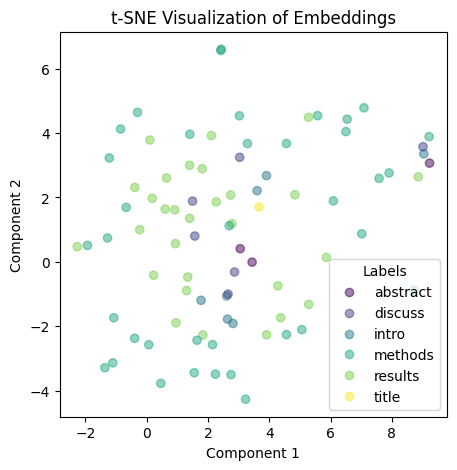

In [25]:
# Tokenize sentences
encoded_input = tokenizer(df_filtered['sentence'].to_list(), padding=True, truncation=False, return_tensors='pt')

# Compute token embeddings
with torch.no_grad():
    model_output = model(**encoded_input)

# Perform pooling
sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

# Normalize embeddings
sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)

# print("Sentence embeddings:")
# print(sentence_embeddings)

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42)
entity_embeddings_2d = tsne.fit_transform(sentence_embeddings)

# Get labels
label_encoder = LabelEncoder()
sections_enc = label_encoder.fit_transform(df_filtered['section'])


# Plot the embeddings
plt.figure(figsize=(5, 5))
scatter = plt.scatter(entity_embeddings_2d[:, 0], entity_embeddings_2d[:, 1], alpha=0.5, c=sections_enc, )

# # Annotate a few points (e.g., the first 10 entities)
# for i, label in enumerate(df_filtered['sentence']):
#     if i < 10:  # Change this to annotate more points
#         plt.annotate(label[:30], (entity_embeddings_2d[i, 0], entity_embeddings_2d[i, 1]))

# Mapping encoded labels back to original labels in the legend
handles, _ = scatter.legend_elements()
original_labels = label_encoder.inverse_transform(range(len(handles)))

# Add a legend with the original (non-encoded) labels
plt.legend(handles, original_labels, title="Labels")

plt.title('t-SNE Visualization of Embeddings')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()


### now collapsing whole sections into one text

In [21]:
collapsed = collapse_sections(df_filtered, 'biocjson')

for i, section in enumerate(collapsed['text']):

    smaller = get_smaller_texts(section, 350)

    collapsed.at[i, 'text'] = smaller

collapsed

,section,pmid,pmcid,date,authors,journal,text
0,abstract,26158728,PMC4497619,2015-07-09 00:00:00+00:00,Himmelstein DS and Baranzini SE,PLoS Comput Biol,[The first decade of Genome Wide Association S...
1,discuss,26158728,PMC4497619,2015-07-09 00:00:00+00:00,Himmelstein DS and Baranzini SE,PLoS Comput Biol,"[Discussion . In this work, we developed a fra..."
2,intro,26158728,PMC4497619,2015-07-09 00:00:00+00:00,Himmelstein DS and Baranzini SE,PLoS Comput Biol,"[Introduction . In the last decade, genome-wid..."
3,methods,26158728,PMC4497619,2015-07-09 00:00:00+00:00,Himmelstein DS and Baranzini SE,PLoS Comput Biol,[Methods . Ethics statement . This study was a...
4,results,26158728,PMC4497619,2015-07-09 00:00:00+00:00,Himmelstein DS and Baranzini SE,PLoS Comput Biol,[Results . Constructing a heterogeneous networ...
5,title,26158728,PMC4497619,2015-07-09 00:00:00+00:00,Himmelstein DS and Baranzini SE,PLoS Comput Biol,[Heterogeneous Network Edge Prediction: A Data...


Note: Bert and mpnet use wordpiece tokenization. Special characteres are treated as individual tokens :)

In [26]:
exploded = collapsed.explode('text')

In [31]:
# Tokenize sentences
encoded_input = tokenizer(
    exploded['text'].to_list(), 
    padding=True, 
    truncation=False, 
    return_tensors='pt'
)

# Compute token embeddings
with torch.no_grad():
    model_output = model(**encoded_input)

# Perform pooling
sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

# Normalize embeddings
sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)

print("Sentence embeddings:")
print(sentence_embeddings)


Sentence embeddings:
tensor([[-0.0337,  0.0422, -0.0127,  ..., -0.0122, -0.0804, -0.0457],
        [-0.0435,  0.0277, -0.0322,  ..., -0.0095, -0.1042, -0.0519],
        [-0.0431,  0.0531, -0.0121,  ..., -0.0013, -0.0892, -0.0241],
        ...,
        [-0.0096, -0.0016, -0.0079,  ..., -0.0223, -0.0832, -0.0339],
        [ 0.0071,  0.0091, -0.0068,  ...,  0.0028, -0.0283, -0.0236],
        [-0.0537,  0.0429, -0.0429,  ..., -0.0179, -0.0668, -0.0314]])


In [44]:
exploded['embedding'] = pd.Series(sentence_embeddings.numpy().tolist())

In [35]:
np_arr = sentence_embeddings.detach().numpy()

In [45]:
exploded

,section,pmid,pmcid,date,authors,journal,text,embedding
0,abstract,26158728,PMC4497619,2015-07-09 00:00:00+00:00,Himmelstein DS and Baranzini SE,PLoS Comput Biol,The first decade of Genome Wide Association St...,"[-0.03368156775832176, 0.04216175526380539, -0..."
0,abstract,26158728,PMC4497619,2015-07-09 00:00:00+00:00,Himmelstein DS and Baranzini SE,PLoS Comput Biol,Disease-associated genes provide clues for elu...,"[-0.03368156775832176, 0.04216175526380539, -0..."
1,discuss,26158728,PMC4497619,2015-07-09 00:00:00+00:00,Himmelstein DS and Baranzini SE,PLoS Comput Biol,"Discussion . In this work, we developed a fram...","[-0.043536942452192307, 0.027730075642466545, ..."
1,discuss,26158728,PMC4497619,2015-07-09 00:00:00+00:00,Himmelstein DS and Baranzini SE,PLoS Comput Biol,Since many existing prioritization techniques ...,"[-0.043536942452192307, 0.027730075642466545, ..."
1,discuss,26158728,PMC4497619,2015-07-09 00:00:00+00:00,Himmelstein DS and Baranzini SE,PLoS Comput Biol,We reason that the desirable qualities of our ...,"[-0.043536942452192307, 0.027730075642466545, ..."
2,intro,26158728,PMC4497619,2015-07-09 00:00:00+00:00,Himmelstein DS and Baranzini SE,PLoS Comput Biol,"Introduction . In the last decade, genome-wide...","[-0.04314460605382919, 0.053127843886613846, -..."
2,intro,26158728,PMC4497619,2015-07-09 00:00:00+00:00,Himmelstein DS and Baranzini SE,PLoS Comput Biol,A similar approach was developed by our group ...,"[-0.04314460605382919, 0.053127843886613846, -..."
2,intro,26158728,PMC4497619,2015-07-09 00:00:00+00:00,Himmelstein DS and Baranzini SE,PLoS Comput Biol,Other techniques operate on multi-relational (...,"[-0.04314460605382919, 0.053127843886613846, -..."
3,methods,26158728,PMC4497619,2015-07-09 00:00:00+00:00,Himmelstein DS and Baranzini SE,PLoS Comput Biol,Methods . Ethics statement . This study was ap...,"[-0.027576664462685585, 0.06940649449825287, -..."
3,methods,26158728,PMC4497619,2015-07-09 00:00:00+00:00,Himmelstein DS and Baranzini SE,PLoS Comput Biol,"In some cases, quality concerns prevented the ...","[-0.027576664462685585, 0.06940649449825287, -..."


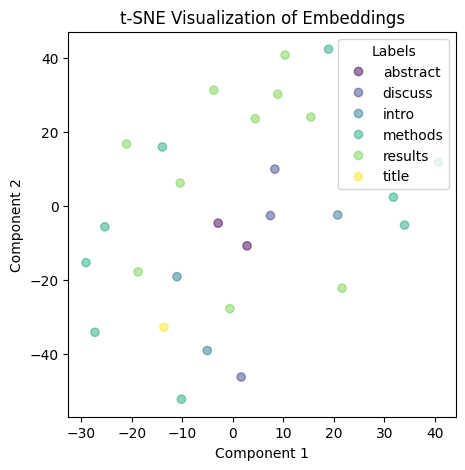

In [38]:

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=10)
entity_embeddings_2d = tsne.fit_transform(np_arr)

# Get labels
label_encoder = LabelEncoder()
sections_enc = label_encoder.fit_transform(exploded['section'])


# Plot the embeddings
plt.figure(figsize=(5, 5))
scatter = plt.scatter(
    entity_embeddings_2d[:, 0], 
    entity_embeddings_2d[:, 1], 
    alpha=0.5, 
    c=sections_enc, 
)

# # Annotate a few points (e.g., the first 10 entities)
# for i, label in enumerate(df_filtered['sentence']):
#     if i < 10:  # Change this to annotate more points
#         plt.annotate(label[:30], (entity_embeddings_2d[i, 0], entity_embeddings_2d[i, 1]))

# Mapping encoded labels back to original labels in the legend
handles, _ = scatter.legend_elements()
original_labels = label_encoder.inverse_transform(range(len(handles)))

# Add a legend with the original (non-encoded) labels
plt.legend(handles, original_labels, title="Labels")

plt.title('t-SNE Visualization of Embeddings')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()
